In [ ]:
### An environment configuration
# python: 3.7.3
# numpy: 1.16.4
# pandas: 0.24.2
# csv: 1.0
# pattern: 3.6
# pyLDAvis: 2.1.2
# matplotlib: 3.1.0
# re: 2.2.1
# gensim: 3.8.1
# wordcloud: 1.6.0
# ipywidgets: 7.5.0
# IPython: 7.6.1
!pip install pattern
!pip install pyLDAvis
!pip install gensim
!pip install wordcloud

In [1]:
import numpy as np
import pandas as pd
import csv
import pattern
import pyLDAvis.gensim as gensimvis
import matplotlib.pyplot as plt
import itertools
import re
from gensim.utils import lemmatize
from gensim.corpora import Dictionary
from gensim.corpora import MmCorpus
from gensim.models.ldamodel import LdaModel
from gensim.models import hdpmodel
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud
from ipywidgets import widgets
from IPython.core.display import HTML, display
import time


C:\Users\myzha\anaconda3\lib\site-packages\pattern\text\__init__.py:52: DeprecationWarning: invalid escape sequence \[
  PUNCTUATION = ".,;:!?()\[]{}`'\"@#$^&*+-|=~_”—“"
C:\Users\myzha\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
df = pd.read_csv("test.csv",sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6525 entries, 0 to 6524
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  6525 non-null   object
dtypes: object(1)
memory usage: 102.0+ KB


In [3]:
df = df.dropna()
df.info()
df.description[:]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6525 entries, 0 to 6524
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  6525 non-null   object
dtypes: object(1)
memory usage: 102.0+ KB


0       Tarek's Home Page Tarek F. Abdelzaher Professo...
1       Sarita Adve University of Illinois at Urbana-C...
2       Home Bio Research Publications Research Group ...
3       Gul A Agha Professor 2104 Siebel Center for Co...
4       Abdussalam Alawini Teaching Assistant Professo...
                              ...                        
6520    Dean M. Tullsen I am a professor and chair of ...
6521    Victor Vianu Professor, Computer Science and E...
6522    Geoffrey M. Voelker Professor research Systems...
6523    Home Research Publications News People Teachin...
6524    Yuanyuan Zhou Qualcomm Endowed Chair Professor...
Name: description, Length: 6525, dtype: object

In [4]:
def decode(s):
    return s.decode('utf-8').split('/')[0]
def stop_word_lem(doc):
    # time.sleep(900/1000)
    return lemmatize(doc, stopwords=STOPWORDS)
    
def lemm(corpus):
    cor_lem = []
    doc_lem = list(map(stop_word_lem,corpus))
    for i,doc in enumerate(doc_lem):
        cor_lem.append(list(map(decode,doc)))
        if i % 500 == 0:
            print(i)
    return cor_lem

# Lemmatize, Stopword removal

In [5]:
print('-Start Lemmatize-')
cor_lemm = lemm(df.description[:])
print('-End Lemmatize-')

-Start Lemmatize-
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
-End Lemmatize-


In [6]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(cor_lemm, min_count=20)
cor_lemm_add_bi = cor_lemm.copy()
for idx in range(len(cor_lemm_add_bi)):
    for token in bigram[cor_lemm_add_bi[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            cor_lemm_add_bi[idx].append(token)



# Build Dictionary

In [7]:
len(cor_lemm_add_bi)

6525

In [8]:
common_dictionary = Dictionary(cor_lemm_add_bi)

In [9]:
common_corpus = [common_dictionary.doc2bow(text) for text in cor_lemm_add_bi]

In [10]:
print('Number of unique tokens: %d' % len(common_dictionary))
print('Number of documents: %d' % len(common_corpus))

Number of unique tokens: 99472
Number of documents: 6525


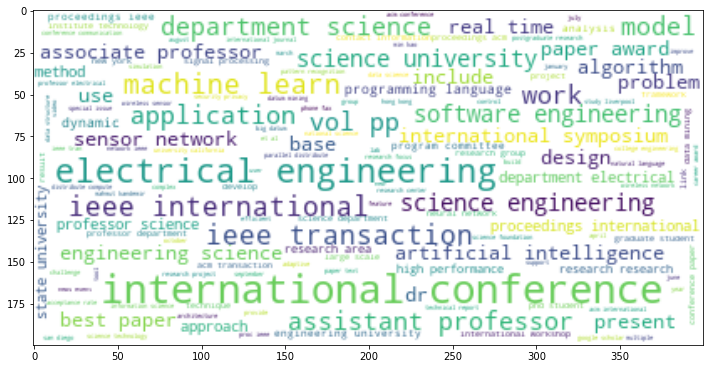

In [11]:
# word cloud visualiztion to glance the corpus outlook
word_collection = itertools.chain.from_iterable(cor_lemm_add_bi)
wordcloud = WordCloud(background_color='white').generate(' '.join(word_collection))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("on")
plt.show()

# LDA

In [12]:
# Train LDA model.
# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = common_dictionary[0]
id2word = common_dictionary.id2token

model = LdaModel(
    corpus=common_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [13]:
def show_doc_LDA(d=0):
    
    def takeSecond(elem):
        return elem[1]
    
    top_dis = model.get_document_topics(common_corpus[d])
    top_dis.sort(key = takeSecond, reverse = True)
    
    for top, prob in top_dis: 
        msg = 'Topic %d (weight %.2f): ' % (top, prob)
        if prob > 0.5:
            colour = 'blue'
        elif 0.2 < prob < 0.5:
            colour = 'red'
        else:
            colour = 'green'
        msg += re.sub('.....\*','',model.print_topic(top))
        output = '<h3><span style="color:%s">%s</span></h3>' % (colour , msg)
        display(HTML(output))
        
    display(HTML('<hr/><h5>Processed Document</h5>'))

    doc = cor_lemm_add_bi[d]
    output = ''
    for n in range(len(doc)):
        w = doc[n]
        output += '<span style="color:black">%s</span> ' % (w)
    display(HTML(output))

<>:17: DeprecationWarning: invalid escape sequence \*
<>:17: DeprecationWarning: invalid escape sequence \*
<ipython-input-13-e9bbb2a27eaa>:17: DeprecationWarning: invalid escape sequence \*
  msg += re.sub('.....\*','',model.print_topic(top))


In [15]:
def takeSecond(elem):
        return elem[1]
topicdictionary = model.get_document_topics(common_corpus[0])
topicdictionary.sort(key = takeSecond, reverse = True)

for top, prob in topicdictionary: 
    print(top)
    print(prob)



1
0.7089147
9
0.16034657
3
0.077842526
0
0.048608102


In [20]:
widgets.interact(show_doc_LDA, d=(760, len(cor_lemm_add_bi)-1))

interactive(children=(IntSlider(value=760, description='d', max=6524, min=760), Output()), _dom_classes=('widg…

<function __main__.show_doc_LDA(d=0)>

In [17]:
vis_data = gensimvis.prepare(model, common_corpus, common_dictionary)
import pyLDAvis
pyLDAvis.display(vis_data)

# Save to researchinterest.txt

In [ ]:
def save_doc_LDA(d=0):
    
    def takeSecond(elem):
        return elem[1]
    
   
    top_dis = model.get_document_topics(common_corpus[d])
    top_dis.sort(key = takeSecond, reverse = True)
    
    for top, prob in top_dis: 
        msg = 'Topic %d (weight %.2f): ' % (top, prob)
        if prob > 0.5:
            colour = 'blue'
        elif 0.2 < prob < 0.5:
            colour = 'red'
        else:
            colour = 'green'
        msg += re.sub('.....\*','',model.print_topic(top))
        break
    return msg


In [ ]:
researchinteresttopiclist = []
for i in range (6524):
    researchinteresttopiclist.append(save_doc_LDA(i))

#print(researchinteresttopiclist)

with open('researchinterest.txt', 'w') as f:
    for item in researchinteresttopiclist:
        # print(item)
        f.write("%s\n" % item)  